# CS-E-106: Data Modeling
## Fall 2019: HW 07

### Important References and Links

*1. Link for model selection in R and Python:*

https://www.r-bloggers.com/practical-machine-learning-with-r-and-python-part-3/

*2. `mlxtend` package for Feature Selection*

- `ExhaustiveFeatureSelector`: https://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/
- `SequentialFeatureSelector`: https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/


*Note:* This package does not give any additional model selection measures like Cp, AIC, BIC, etc. by default. See custom functions below (#5).

    
*4. PRESS statistic:*

https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html

*5. Feature selection blog (custom functions):*

- https://xavierbourretsicotte.github.io/subset_selection.html
- http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html
- https://github.com/JWarmenhoven/ISLR-python

In [1]:
# ! pip install mlxtend

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import time
import random
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics import gofplots
import pylab
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### Utility Functions

In [174]:
def scale_numeric(fit_df, trans_df, cols):
    df_scaled = trans_df[cols].copy()
    scaler = StandardScaler().fit(fit_df[cols])
    df_scaled = pd.DataFrame(scaler.transform(df_scaled), index=df_scaled.index, columns=cols)
    return(df_scaled)

def scale_encode(fit_df, trans_df, scale_num=True):
    num_cols = list(fit_df.columns[(fit_df.dtypes == 'float64') | (fit_df.dtypes == 'int64')])
    str_cols = list(set(fit_df.columns)^set(num_cols))

    if (len(num_cols)>0) & (len(str_cols)>0):
        if scale_num:
            df_scaled = scale_numeric(fit_df=fit_df, trans_df=trans_df, cols=num_cols)
        else:
            df_scaled = trans_df[num_cols].copy()
        df_dummy = pd.get_dummies(trans_df[str_cols])
        df =  df_scaled.join(df_dummy)
    elif len(str_cols)>0:
        df = pd.get_dummies(trans_df[str_cols])
    elif len(num_cols)>0:
        if scale_num:
            df = scale_numeric(fit_df=fit_df, trans_df=trans_df, cols=num_cols)
        else:
            df = trans_df[num_cols].copy()
    else:
        df = trans_df.copy()
    
    return(df)

### Stepwise Regression Functions:
**Reference:** http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html from #5 above.

In [167]:
def processSubset(X_subset, y_subset):
    # Fit model on feature_set and calculate RSS
    X_dummy = scale_encode(fit_df=X_subset, trans_df=X_subset, scale_num=False)
    X = sm.add_constant(X_dummy)
    model = sm.OLS(y,X).fit()
    RSS = ((model.predict(X) - y)**2).sum()
    return {"model":model, "RSS":RSS}

def best_subset_models(X,y):
    
    models_best = pd.DataFrame(columns=["RSS", "model"])
    
    for i in range(1,len(X.columns)+1):
        
        tic = time.time()

        results = []

        for combo in itertools.combinations(X.columns, i):
            results.append(processSubset(X_subset=X[list(combo)], y_subset=y))

        # Wrap everything up in a nice dataframe
        models = pd.DataFrame(results)

        # Choose the model with the highest RSS
        best_model = models.loc[models['RSS'].argmin()]

        toc = time.time()
        print("Processed", models.shape[0], "models on", i, "predictors in", (toc-tic), "seconds.")
        
        models_best.loc[i] = best_model
    
    # Return the best model, along with some other useful information about the model
    return models_best


def forward_stepwise(X,y):
    
    predictors = []
    models_fwd = pd.DataFrame(columns=["RSS", "model"])
    
    for i in range(1,len(X.columns)+1):
        
        # Pull out predictors we still need to process
        remaining_predictors = [p for p in X.columns if p not in predictors]
        
        tic = time.time()

        results = []

        for p in remaining_predictors:
            results.append(processSubset(X_subset=X[predictors+[p]], y_subset=y))

        # Wrap everything up in a nice dataframe
        models = pd.DataFrame(results)

        # Choose the model with the highest RSS
        best_model = models.loc[models['RSS'].argmin()]

        toc = time.time()
        print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
        models_fwd.loc[i] = best_model
        predictors = models_fwd.loc[i]["model"].model.exog_names
        predictors = list(set(predictors)^set(["const"]))
    
    # Return the best model, along with some other useful information about the model
    return models_fwd


def backward_stepwise(X,y):
    
    predictors = X.columns    
    models_bwd = pd.DataFrame(columns=["RSS", "model"])
    
    for i in range(1,len(X.columns)+1):
        
        # Pull out predictors we still need to process
        remaining_predictors = [p for p in X.columns if p not in predictors]
        
        tic = time.time()

        results = []
        
        for combo in itertools.combinations(predictors, len(predictors)-1):
            results.append(processSubset(X_subset=X[list(combo)], y_subset=y))

        # Wrap everything up in a nice dataframe
        models = pd.DataFrame(results)

        # Choose the model with the highest RSS
        best_model = models.loc[models['RSS'].argmin()]

        toc = time.time()
        print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
        models_bwd.loc[len(predictors)-1] = best_model
        predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names
        predictors = list(set(predictors)^set(["const"]))
    
    # Return the best model, along with some other useful information about the model
    return models_bwd

In [161]:
def plot_model_stats(models_best):
    plt.figure(figsize=(20,15))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x3 grid so we can look at 6 plots at once
    plt.subplot(3, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["RSS"])
    plt.xlabel('# Predictors')
    plt.ylabel('RSS')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    
    # Adjusted R2
    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(3, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    
    # AIC
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(3, 2, 3)
    plt.plot(aic)
    plt.plot(aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')
    
    # BIC
    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(3, 2, 4)
    plt.plot(bic)
    plt.plot(bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
    
#     # Cp    
#     cp = models_best.apply(lambda row: row[1].cp, axis=1)

#     plt.subplot(2, 2, 4)
#     plt.plot(bic)
#     plt.plot(bic.argmin(), bic.min(), "or")
#     plt.xlabel('# Predictors')
#     plt.ylabel('Cp')
    
    # PRESS    
    press = models_best.apply(lambda row: OLSInfluence(row[1]).ess_press, axis=1)
    
    plt.subplot(3, 2, 5)
    plt.plot(press)
    plt.plot(press.argmax(), bic.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('PRESS')

**Question 1:** Refer to the CDI data set. A regression model relating serious crime rate (Y, total serious crimes divided by total population) to population density (X1, total population divided by land area) and unemployment rate (X3) is to be constructed. (15 pts)

**(a)** Fit second-order regression model (equation 8.8 on the book). Plot the residuals against the fitted values. How well does the second-order model appear to fit the data? What is R2? (5pts)

**Solution:**

In [6]:
cdi_data = pd.read_csv("data/CDI.csv")

df_1 = cdi_data

Y = df_1["Total serious crimes"]/df_1["Total population"]
X1 = df_1["Total population"]/df_1["Land area"]
X3 = df_1["Percent unemployment"]

df_1["x1"] = (X1-np.mean(X1))/np.std(X1)
df_1["x3"] = (X3-np.mean(X3))/np.std(X3)
df_1["x1sqr"] = df_1["x1"]**2
df_1["x3sqr"] = df_1["x3"]**2
df_1["x1x3"] = df_1["x1"]*df_1["x3"]

In [7]:
lm_cdi_1a = ols("Y~x1+x3+x1sqr+x3sqr+x1x3", data=df_1).fit()
lm_cdi_1a.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.240     
Dependent Variable: Y                AIC:                -2033.8930
Date:               2019-11-20 20:19 BIC:                -2009.3723
No. Observations:   440              Log-Likelihood:     1022.9    
Df Model:           5                F-statistic:        28.70     
Df Residuals:       434              Prob (F-statistic): 3.69e-25  
R-squared:          0.248            Scale:              0.00056771
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
Intercept     0.0563     0.0013   44.6625   0.0000    0.0538   0.0588
x1            0.0101     0.0022    4.6589   0.0000    0.0058   0.0143
x3           -0.0002     0.0015   -0.1402   0.8886   -0.0031   0.0027
x1sqr         0.0000     0.0003    0.0455   0.9637   -0.0005   0.0006
x3sqr         0.0009     0.0005    1.7076   0.0884   -0.0001   0.0019
x1x3          0.0043     0.0021    2.0368   0.0423    0.0001   0.0084
-------------------------------------------------------------------
Omnibus:              22.989        Durbin-Watson:           1.787 
Prob(Omnibus):        0.000         Jarque-Bera (JB):        25.127
Skew:                 0.571         Prob(JB):                0.000 
Kurtosis:             3.260         Condition No.:           21    
===================================================================

"""

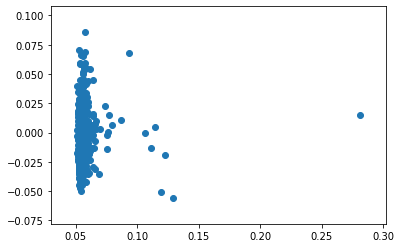

In [8]:
ei = lm_cdi_1a.resid
fitted_values = lm_cdi_1a.fittedvalues
plt.scatter(fitted_values,ei)

In [9]:
coeffs = lm_cdi_1a.params
coeffs

Intercept    0.056288
x1           0.010052
x3          -0.000205
x1sqr        0.000013
x3sqr        0.000889
x1x3         0.004266
dtype: float64

In [10]:
print("The regression model is Yhat = %s + %s*x1 + %s*x3 + %s*x1sqr + %s*x3sqr + %s*x1x3" %(coeffs["Intercept"], coeffs["x1"], coeffs["x3"], coeffs["x1sqr"], coeffs["x3sqr"], coeffs["x1x3"]))

The regression model is Yhat = 0.05628803374324597 + 0.01005156005150148*x1 + -0.0002054996301641967*x3 + 1.2966975612571088e-05*x1sqr + 0.0008885208310572405*x3sqr + 0.004266375165763692*x1x3


In [11]:
print("R-squared = %s"%lm_cdi_1a.rsquared)

R-squared = 0.24847487775386223


We can see that the regression model is not a very great fit based on the $R^2$ and the residual plot (we can see outliers and non-constant variance in the error terms).

**(b)** 

Test whether or not all quadratic and interaction terms can be dropped from the regression model; use α = .01. State the alternatives, decision rule, and conclusion. (5pts)

**Solution:**

In [12]:
lm_cdi_1b = ols("Y~x1+x3", data=df_1).fit()
lm_cdi_1b.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.228     
Dependent Variable: Y                AIC:                -2030.2191
Date:               2019-11-20 20:19 BIC:                -2017.9588
No. Observations:   440              Log-Likelihood:     1018.1    
Df Model:           2                F-statistic:        65.92     
Df Residuals:       437              Prob (F-statistic): 9.55e-26  
R-squared:          0.232            Scale:              0.00057634
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
Intercept     0.0573     0.0011   50.0538   0.0000    0.0550   0.0595
x1            0.0131     0.0011   11.4387   0.0000    0.0108   0.0153
x3            0.0008     0.0011    0.7379   0.4609   -0.0014   0.0031
-------------------------------------------------------------------
Omnibus:              20.529        Durbin-Watson:           1.818 
Prob(Omnibus):        0.000         Jarque-Bera (JB):        22.164
Skew:                 0.542         Prob(JB):                0.000 
Kurtosis:             3.188         Condition No.:           1     
===================================================================

"""

In [13]:
anova_lm(lm_cdi_1b, lm_cdi_1a)

/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,437.0,0.251862,0.0,NaN,NaN,NaN
1,434.0,0.246385,3.0,0.005477,3.215874,0.022775


In [14]:
FStar = 3.2159 # from the above anova 

df_diff = 3
df_E = lm_cdi_1b.df_resid
alpha = 0.01
FTest = stats.f.ppf(1-alpha, df_diff, df_E)
print(FTest)

3.826715087291002


*Hypotheses:*

$H_0: \beta_{11} = \beta_{33} = \beta_{13} = 0$ 

$H_a:$ Not all $\beta$'s are equal to zero


*Decision Rules:*

If $F^* \leq$ `r FTest`, conclude $H_0$

If $F^* >$ `r FTest`, conclude $H_a$

*Conclusion:*

Since our test statistic, $F^* =$ `r FStar`, and `r FStar` $\leq$ `r FTest`, we conclude $H_0$. Also, we can see that the p-value is 0.02278 (from ANOVA) which is greater that the given $\alpha=0.01$. Thus, we can remove all the quadratic and interaction terms.

**(c)** 

Instead of the predictor variable population density, total population (X1) and land area (X2) are to be employed as separate predictor variables, in addition to unemployment rate (X3). The regression model should contain linear and quadratic terms for total population, and linear terms only for land area and unemployment rate. (No interaction terms are to be included in this model.) Fit this regression model and obtain R2. Is this coefficient of multiple determination substantially different from the one for the regression model in part a? (5pts)

**Solution:**


In [15]:
df_1c = cdi_data
X1 = cdi_data["Total population"]
X2 = cdi_data["Land area"]
X3 = cdi_data["Percent unemployment"]

df_1c["x1"] = (X1-np.mean(X1))/np.std(X1)
df_1c["x2"] = (X2-np.mean(X2))/np.std(X2)
df_1c["x3"] = (X3-np.mean(X3))/np.std(X3)
df_1c["x1sqr"] = df_1c["x1"]**2


In [16]:
lm_cdi_1c = ols("Y~x1+x2+x3+x1sqr", data=df_1c).fit()
lm_cdi_1c.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.137     
Dependent Variable: Y                AIC:                -1978.8248
Date:               2019-11-20 20:19 BIC:                -1958.3909
No. Observations:   440              Log-Likelihood:     994.41    
Df Model:           4                F-statistic:        18.35     
Df Residuals:       435              Prob (F-statistic): 6.02e-14  
R-squared:          0.144            Scale:              0.00064484
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
Intercept    0.0585     0.0012   47.5952   0.0000    0.0561    0.0609
x1           0.0177     0.0021    8.2762   0.0000    0.0135    0.0219
x2          -0.0009     0.0013   -0.6865   0.4927   -0.0033    0.0016
x3           0.0016     0.0012    1.2873   0.1987   -0.0008    0.0040
x1sqr       -0.0012     0.0002   -5.7095   0.0000   -0.0016   -0.0008
-------------------------------------------------------------------
Omnibus:             160.964       Durbin-Watson:          1.967   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       1090.601
Skew:                1.404         Prob(JB):               0.000   
Kurtosis:            10.184        Condition No.:          18      
===================================================================

"""

In [17]:
anova_lm(lm_cdi_1c, lm_cdi_1a)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,435.0,0.280506,0.0,NaN,NaN,NaN
1,434.0,0.246385,1.0,0.034121,60.103526,6.460433e-14


In [18]:
print("R-squared = %s" %lm_cdi_1c.rsquared)

R-squared = 0.14439812795141238


*Interpretation:* 

We can see from the ANOVA that the model in Q1(c) is substantially different than the one in part (a), since the p-value is very low (<<0.001). Also, the $R^2$ is substantially different for the two models.


**Question 2** Refer to the CDI data set. The number of active physicians (Y) is to be regressed against total population (X1), total personal income (X2), and geographic region (X3, X4, X5). (15pts)

**(a)** Fit a first-order regression model. Let X3 =1 if NE and 0 otherwise, X4 = 1 if NC and 0 otherwise, and X5 = 1I if S and 0 otherwise. (5pts)


**Solution:**

In [19]:
df_2 = cdi_data

df_2["Y"] = df_2["Number of active physicians"]
df_2["X1"] = df_2["Total population"]
df_2["X2"] = df_2["Total personal income"]
df_2["X3"] = pd.get_dummies(df_2["Geographic region"])[1]
df_2["X4"] = pd.get_dummies(df_2["Geographic region"])[2]
df_2["X5"] = pd.get_dummies(df_2["Geographic region"])[3]

In [20]:
lm_cdi_2a = ols("Y~X1+X2+X3+X4+X5", data=df_2).fit()
lm_cdi_2a.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.900     
Dependent Variable: Y                AIC:                6832.7739 
Date:               2019-11-20 20:19 BIC:                6857.2946 
No. Observations:   440              Log-Likelihood:     -3410.4   
Df Model:           5                F-statistic:        790.7     
Df Residuals:       434              Prob (F-statistic): 1.94e-215 
R-squared:          0.901            Scale:              3.2049e+05
--------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|     [0.025    0.975] 
--------------------------------------------------------------------
Intercept  -207.4957   70.2816  -2.9523  0.0033  -345.6304  -69.3611
X1            0.0006    0.0003   1.9449  0.0524    -0.0000    0.0011
X2            0.1070    0.0133   8.0733  0.0000     0.0810    0.1331
X3          149.0196   86.8332   1.7162  0.0868   -21.6462  319.6854
X4          145.5264   85.1529   1.7090  0.0882   -21.8370  312.8898
X5          191.2163   80.0330   2.3892  0.0173    33.9158  348.5168
-------------------------------------------------------------------
Omnibus:             287.005       Durbin-Watson:          2.106   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       3872.740
Skew:                2.603         Prob(JB):               0.000   
Kurtosis:            16.570        Condition No.:          3735632 
===================================================================
* The condition number is large (4e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

**(b)** 

Examine whether the effect for the northeastern region on number of active physicians differs from the effect for the north central region by constructing an appropriate 90 percent confidence interval. Interpret your interval estimate. (5pts)

In [21]:
alpha = 0.1
lm_cdi_2a.conf_int(alpha=alpha)

,0,1
Intercept,-323.345998,-91.645500
X1,0.000084,0.001019
X2,0.085162,0.128861
X3,5.886209,292.152935
X4,5.162733,285.890159
X5,59.292112,323.140497


*Interpretation:*

The confidence interval estimates for Northeastern region (X3) are not significantly different that those for Northcentral region (X4).

**(c)** 

Test whether any geographic effects are present; use α= .10. State the alternatives, decision rule, and conclusion. What is the P-value of the test? (5pts)

In [22]:
lm_cdi_2c = ols("Y~X1+X2", data=df_2).fit()
display(lm_cdi_2c.summary2())
anova_lm(lm_cdi_2c, lm_cdi_2a)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.899     
Dependent Variable: Y                AIC:                6832.6613 
Date:               2019-11-20 20:19 BIC:                6844.9216 
No. Observations:   440              Log-Likelihood:     -3413.3   
Df Model:           2                F-statistic:        1961.     
Df Residuals:       437              Prob (F-statistic): 5.41e-219 
R-squared:          0.900            Scale:              3.2258e+05
--------------------------------------------------------------------
               Coef.    Std.Err.     t     P>|t|     [0.025   0.975]
--------------------------------------------------------------------
Intercept     -64.4382   32.8258  -1.9630  0.0503  -128.9543  0.0779
X1              0.0005    0.0003   1.9135  0.0563    -0.0000  0.0011
X2              0.1072    0.0130   8.2692  0.0000     0.0817  0.1327
-------------------------------------------------------------------
Omnibus:             287.580       Durbin-Watson:          2.117   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       3874.314
Skew:                2.611         Prob(JB):               0.000   
Kurtosis:            16.567        Condition No.:          871067  
===================================================================
* The condition number is large (9e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,437.0,1.409671e+08,0.0,NaN,NaN,NaN
1,434.0,1.390935e+08,3.0,1.873626e+06,1.948699,0.121032


In [23]:
FStar = 1.9487 # from the above anova 

df_diff = 3
df_E = lm_cdi_1b.df_resid
alpha = 0.1
FTest = stats.f.ppf(1-alpha, df_diff, df_E)
print(FTest)

2.0963615332508763


*Hypotheses:*

$H_0: \beta_{3} = \beta_{4} = \beta_{5} = 0$ 

$H_a:$ Not all $\beta$'s are equal to zero


*Decision Rules:*

If $F^* \leq$ `r FTest`, conclude $H_0$

If $F^* >$ `r FTest`, conclude $H_a$

*Conclusion:*

Since our test statistic, $F^* =$ `r FStar`, and `r FStar` $\leq$ `r FTest`, we conclude $H_0$. Thus, the geographic effects are not present.

**Quuestion 3** Refer to the Lung pressure Data. Increased arterial blood pressure in the lungs frequently leads to the development of heart failure in patients with chronic obstructive pulmonary disease (COPD). The standard method for determining arterial lung pressure is invasive, technically difficult, and involves some risk to the patient. Radionuclide imaging is a noninvasive, less risky method for estimating arterial pressure in the lungs. To investigate the predictive ability of this method, a cardiologist collected data on 19 mild-to-moderate COPD patients. The data includes the invasive measure of systolic pulmonary arterial pressure (Y) and three potential noninvasive predictor variables. Two were obtained by using radionuclide imaging emptying rate of blood into the pumping chamber or the heart (X1) and ejection rate of blood pumped out of the heart into the lungs (X2) and the third predictor variable measures blood gas (X3). (25pts)


**(a)** Fit the multiple regression function containing the three predictor variables us first-order terms. Does it appear that all predictor variables should be retained? (5pts)

**Solution:**

In [24]:
lung_data = pd.read_csv("data/Lung Pressure.csv")
lm_lung_3a = ols("Y~X1+X2+X3", data=lung_data).fit()
lm_lung_3a.summary2()

/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.537   
Dependent Variable: Y                AIC:                158.8476
Date:               2019-11-20 20:19 BIC:                162.6254
No. Observations:   19               Log-Likelihood:     -75.424 
Df Model:           3                F-statistic:        7.957   
Df Residuals:       15               Prob (F-statistic): 0.00208 
R-squared:          0.614            Scale:              208.07  
------------------------------------------------------------------
              Coef.   Std.Err.     t     P>|t|    [0.025   0.975] 
------------------------------------------------------------------
Intercept    87.1875   21.5525   4.0454  0.0011  41.2495  133.1255
X1           -0.5645    0.4279  -1.3191  0.2069  -1.4766    0.3476
X2           -0.5132    0.2245  -2.2858  0.0372  -0.9916   -0.0347
X3           -0.0720    0.4546  -0.1583  0.8763  -1.0409    0.8969
-----------------------------------------------------------------
Omnibus:              2.637        Durbin-Watson:           1.171
Prob(Omnibus):        0.268        Jarque-Bera (JB):        1.623
Skew:                 0.716        Prob(JB):                0.444
Kurtosis:             2.979        Condition No.:           458  
=================================================================

"""

In [25]:
anova_lm(lm_lung_3a)

,df,sum_sq,mean_sq,F,PR(>F)
X1,1.0,3577.085399,3577.085399,17.191982,0.000862
X2,1.0,1384.378861,1384.378861,6.653522,0.020938
X3,1.0,5.213752,5.213752,0.025058,0.876334
Residual,15.0,3121.006199,208.067080,NaN,NaN


*Interpretation:* 

We see that the p-value for X2 and X3 show a good linear relation with Y, as they add a significant amount of SSR (based on ANOVA above and looking at the respective p-values). But X3 does not appear to add a significant value to the model when X1 and X2 are already present.

**(b)** Using first-order and second-order terms for each of the three predictor variables (centered around the mean) in the pool of potential X variables (including cross products of the first order terms), find the three best hierarchical subset regression models according to the R2a,p criterion. (5pts)

In [26]:
df_3 = lung_data

Y = df_3["Y"]
X1 = df_3["X1"]
X2 = df_3["X2"]
X3 = df_3["X3"]

df_3["x1"] = (X1-np.mean(X1))/np.std(X1)
df_3["x2"] = (X2-np.mean(X2))/np.std(X2)
df_3["x3"] = (X3-np.mean(X3))/np.std(X3)
df_3["x1sqr"] = df_3["x1"]**2
df_3["x2sqr"] = df_3["x2"]**2
df_3["x3sqr"] = df_3["x3"]**2
df_3["x1x2"] = df_3["x1"]*df_3["x2"]
df_3["x1x3"] = df_3["x1"]*df_3["x3"]
df_3["x2x3"] = df_3["x1"]*df_3["x3"]

In [27]:
lm_lung_3b1 = ols("Y~x1+x2+x3+x1sqr+x2sqr+x3sqr+x1x2+x1x3+x2x3", data=df_3).fit()
lm_lung_3b1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.662   
Dependent Variable: Y                AIC:                155.1594
Date:               2019-11-20 20:19 BIC:                163.6593
No. Observations:   19               Log-Likelihood:     -68.580 
Df Model:           8                F-statistic:        5.408   
Df Residuals:       10               Prob (F-statistic): 0.00787 
R-squared:          0.812            Scale:              151.85  
------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
------------------------------------------------------------------
Intercept    36.9357    5.2016   7.1008  0.0000   25.3458  48.5257
x1           -6.3722    4.8391  -1.3168  0.2173  -17.1545   4.4100
x2          -16.5366    5.9653  -2.7722  0.0197  -29.8281  -3.2452
x3           -0.6799    3.3519  -0.2028  0.8433   -8.1485   6.7887
x1sqr         3.4094    6.5768   0.5184  0.6155  -11.2446  18.0634
x2sqr         4.0524    4.2310   0.9578  0.3607   -5.3747  13.4796
x3sqr        -1.5631    3.3670  -0.4643  0.6524   -9.0652   5.9389
x1x2          0.5822   11.2989   0.0515  0.9599  -24.5932  25.7577
x1x3         -0.5269    2.9443  -0.1790  0.8615   -7.0873   6.0335
x2x3         -0.5269    2.9443  -0.1790  0.8615   -7.0873   6.0335
-----------------------------------------------------------------
Omnibus:           4.589   Durbin-Watson:      1.799             
Prob(Omnibus):     0.101   Jarque-Bera (JB):   2.511             
Skew:              0.832   Prob(JB):           0.285             
Kurtosis:          3.637   Condition No.:      270862265005137696
=================================================================
* The condition number is large (3e+17). This might indicate
strong multicollinearity or other numerical problems.
"""

In [28]:
lm_lung_3b2 = ols("Y~x1+x2+x3+x2sqr+x3sqr+x1x2+x1x3+x2x3", data=df_3).fit()
lm_lung_3b2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.685   
Dependent Variable: Y                AIC:                153.6632
Date:               2019-11-20 20:19 BIC:                161.2187
No. Observations:   19               Log-Likelihood:     -68.832 
Df Model:           7                F-statistic:        6.579   
Df Residuals:       11               Prob (F-statistic): 0.00316 
R-squared:          0.807            Scale:              141.75  
------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
------------------------------------------------------------------
Intercept    38.0738    4.5562   8.3565  0.0000   28.0457  48.1019
x1           -5.5007    4.3843  -1.2546  0.2356  -15.1504   4.1490
x2          -16.9621    5.7088  -2.9713  0.0127  -29.5270  -4.3973
x3           -0.4268    3.2041  -0.1332  0.8964   -7.4789   6.6253
x2sqr         3.2754    3.8228   0.8568  0.4098   -5.1385  11.6892
x3sqr        -2.0818    3.1062  -0.6702  0.5165   -8.9184   4.7548
x1x2          6.1381    3.4569   1.7756  0.1034   -1.4704  13.7466
x1x3          0.1247    2.5725   0.0485  0.9622   -5.5373   5.7868
x2x3          0.1247    2.5725   0.0485  0.9622   -5.5373   5.7868
-----------------------------------------------------------------
Omnibus:          4.723    Durbin-Watson:       1.775            
Prob(Omnibus):    0.094    Jarque-Bera (JB):    2.566            
Skew:             0.827    Prob(JB):            0.277            
Kurtosis:         3.712    Condition No.:       64576486039554384
=================================================================
* The condition number is large (6e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

In [29]:
lm_lung_3b3 = ols("Y~x1+x2+x3+x3sqr+x1x2+x1x3+x2x3", data=df_3).fit()
lm_lung_3b3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.691   
Dependent Variable: Y                AIC:                152.8907
Date:               2019-11-20 20:19 BIC:                159.5018
No. Observations:   19               Log-Likelihood:     -69.445 
Df Model:           6                F-statistic:        7.724   
Df Residuals:       12               Prob (F-statistic): 0.00144 
R-squared:          0.794            Scale:              138.61  
------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
------------------------------------------------------------------
Intercept    38.7931    4.4283   8.7602  0.0000   29.1446  48.4415
x1           -6.8889    4.0285  -1.7100  0.1130  -15.6663   1.8885
x2          -14.0415    4.5283  -3.1008  0.0092  -23.9078  -4.1752
x3           -0.4068    3.1683  -0.1284  0.9000   -7.3099   6.4963
x3sqr        -0.8115    2.6991  -0.3007  0.7688   -6.6924   5.0693
x1x2          8.0316    2.6286   3.0555  0.0100    2.3044  13.7589
x1x3         -0.4137    2.4668  -0.1677  0.8696   -5.7883   4.9609
x2x3         -0.4137    2.4668  -0.1677  0.8696   -5.7883   4.9609
-----------------------------------------------------------------
Omnibus:          4.683    Durbin-Watson:       1.804            
Prob(Omnibus):    0.096    Jarque-Bera (JB):    2.655            
Skew:             0.872    Prob(JB):            0.265            
Kurtosis:         3.557    Condition No.:       53660872398252640
=================================================================
* The condition number is large (5e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

In [30]:
lm_lung_3b4 = ols("Y~x1+x2+x3+x3sqr+x1x2+x2x3", data=df_3).fit()
lm_lung_3b4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.691   
Dependent Variable: Y                AIC:                152.8907
Date:               2019-11-20 20:19 BIC:                159.5018
No. Observations:   19               Log-Likelihood:     -69.445 
Df Model:           6                F-statistic:        7.724   
Df Residuals:       12               Prob (F-statistic): 0.00144 
R-squared:          0.794            Scale:              138.61  
------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
------------------------------------------------------------------
Intercept    38.7931    4.4283   8.7602  0.0000   29.1446  48.4415
x1           -6.8889    4.0285  -1.7100  0.1130  -15.6663   1.8885
x2          -14.0415    4.5283  -3.1008  0.0092  -23.9078  -4.1752
x3           -0.4068    3.1683  -0.1284  0.9000   -7.3099   6.4963
x3sqr        -0.8115    2.6991  -0.3007  0.7688   -6.6924   5.0693
x1x2          8.0316    2.6286   3.0555  0.0100    2.3044  13.7589
x2x3         -0.8274    4.9335  -0.1677  0.8696  -11.5766   9.9219
-----------------------------------------------------------------
Omnibus:              4.683        Durbin-Watson:           1.804
Prob(Omnibus):        0.096        Jarque-Bera (JB):        2.655
Skew:                 0.872        Prob(JB):                0.265
Kurtosis:             3.557        Condition No.:           4    
=================================================================

"""

In [31]:
lm_lung_3b5 = ols("Y~x1+x2+x3+x1x2+x2x3", data=df_3).fit()
lm_lung_3b5.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.713   
Dependent Variable: Y                AIC:                151.0333
Date:               2019-11-20 20:19 BIC:                156.7000
No. Observations:   19               Log-Likelihood:     -69.517 
Df Model:           5                F-statistic:        9.947   
Df Residuals:       13               Prob (F-statistic): 0.000434
R-squared:          0.793            Scale:              128.92  
------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
------------------------------------------------------------------
Intercept    37.8664    3.0664  12.3488  0.0000   31.2418  44.4909
x1           -6.9793    3.8742  -1.8015  0.0949  -15.3490   1.3904
x2          -14.1959    4.3388  -3.2718  0.0061  -23.5693  -4.8225
x3           -0.4026    3.0554  -0.1318  0.8972   -7.0034   6.1982
x1x2          8.2236    2.4590   3.3442  0.0053    2.9112  13.5361
x2x3         -0.6068    4.7049  -0.1290  0.8993  -10.7712   9.5576
-----------------------------------------------------------------
Omnibus:              5.041        Durbin-Watson:           1.759
Prob(Omnibus):        0.080        Jarque-Bera (JB):        2.879
Skew:                 0.897        Prob(JB):                0.237
Kurtosis:             3.645        Condition No.:           4    
=================================================================

"""

In [32]:
lm_lung_3b6 = ols("Y~x1+x2+x1x2+x2x3", data=df_3).fit()
lm_lung_3b6.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.733   
Dependent Variable: Y                AIC:                149.0587
Date:               2019-11-20 20:19 BIC:                153.7809
No. Observations:   19               Log-Likelihood:     -69.529 
Df Model:           4                F-statistic:        13.37   
Df Residuals:       14               Prob (F-statistic): 0.000108
R-squared:          0.793            Scale:              119.87  
------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
------------------------------------------------------------------
Intercept    37.8613    2.9566  12.8057  0.0000   31.5200  44.2025
x1           -7.1348    3.5582  -2.0052  0.0647  -14.7665   0.4968
x2          -13.9298    3.7030  -3.7618  0.0021  -21.8720  -5.9877
x1x2          8.2297    2.3708   3.4713  0.0037    3.1449  13.3145
x2x3         -0.6314    4.5333  -0.1393  0.8912  -10.3543   9.0915
-----------------------------------------------------------------
Omnibus:              5.546        Durbin-Watson:           1.720
Prob(Omnibus):        0.062        Jarque-Bera (JB):        3.287
Skew:                 0.961        Prob(JB):                0.193
Kurtosis:             3.675        Condition No.:           3    
=================================================================

"""

In [33]:
lm_lung_3b7 = ols("Y~x1+x2+x1x2", data=df_3).fit()
lm_lung_3b7.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.751   
Dependent Variable: Y                AIC:                147.0850
Date:               2019-11-20 20:19 BIC:                150.8628
No. Observations:   19               Log-Likelihood:     -69.543 
Df Model:           3                F-statistic:        19.06   
Df Residuals:       15               Prob (F-statistic): 2.23e-05
R-squared:          0.792            Scale:              112.03  
------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
------------------------------------------------------------------
Intercept    37.8882    2.8522  13.2838  0.0000   31.8089  43.9675
x1           -7.3105    3.2165  -2.2728  0.0382  -14.1663  -0.4548
x2          -13.7224    3.2776  -4.1867  0.0008  -20.7085  -6.7363
x1x2          8.2331    2.2918   3.5923  0.0027    3.3481  13.1180
-----------------------------------------------------------------
Omnibus:              4.466        Durbin-Watson:           1.734
Prob(Omnibus):        0.107        Jarque-Bera (JB):        2.559
Skew:                 0.868        Prob(JB):                0.278
Kurtosis:             3.466        Condition No.:           3    
=================================================================

"""

We can see that `lm_lung_3b5`, `lm_lung_3b6` and `lm_lung_3b7` are the three best hierarchical subset regression models based on Adjusted R-squared.

In [34]:
X = df_3[["x1","x2","x3","x1sqr","x2sqr","x3sqr","x1x2","x1x3","x2x3"]]
Y = df_3["Y"]

In [35]:
lr = LinearRegression()
efs1 = EFS(lr, 
           min_features=1,
           max_features=len(X.columns),
           scoring='r2',
           print_progress=True,
           cv=5)


# Create a efs fit
efs1 = efs1.fit(X.as_matrix(), Y.as_matrix())

/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
Features: 511/511

In [36]:
print('Best R2: %.2f' % efs1.best_score_)
## Print the IDX of the best features 
print('Best subset:', efs1.best_idx_)

Best R2: 0.20
Best subset: (1, 4, 5, 6)


**(c)** Is there much difference in R2a,p for the three best subset models? (5pts)

**Solution:**

`lm_lung_3b5`, `lm_lung_3b6` and `lm_lung_3b7` have an adjusted $R^2$ of 0.7228, 0.7418, 0.7507 respectively. Thus, they have more or less the same adjusted $R^2$.

**(d)** Calculate the PRESS statistic and compare it to SSE. What does this comparison suggest about the validity of MSE as an indicator of the predictive ability of the fitted model? (5pts)

**Solution:**

See links above

In [37]:
display(OLSInfluence(lm_lung_3b7).ess_press)

residuals_press_squared = OLSInfluence(lm_lung_3b7).resid_press**2
display(residuals_press_squared)

5102.494352597143

0      599.857733
1       20.601552
2      100.221227
3       46.774087
4       38.220776
5       61.692510
6      944.435484
7     2546.462424
8       16.840056
9      180.637066
10      66.682554
11       2.112831
12     239.401767
13      61.292429
14       7.630673
15      21.079224
16      68.120022
17       0.457655
18      79.974284
dtype: float64

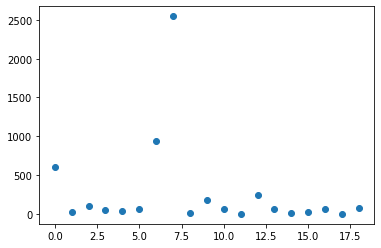

In [38]:
plt.scatter(range(len(residuals_press_squared)),residuals_press_squared)

In [39]:
anova_lm(lm_lung_3b7)

,df,sum_sq,mean_sq,F,PR(>F)
x1,1.0,3577.085399,3577.085399,31.929429,0.000046
x2,1.0,1384.378861,1384.378861,12.357107,0.003124
x1x2,1.0,1445.755148,1445.755148,12.904958,0.002667
Residual,15.0,1680.464802,112.030987,NaN,NaN


SSE is 1680.5 for the best model chosen above and the PRESS stat is 5102.5. This means that there are a few observations in the data set are significantly driving the model's coefficients.

**(e)** Case 8 alone accounts for approximately one-half of the entire PRESS statistic. Would you recommend modification of the model because of the strong impact of this case? What are some corrective action options that would lessen the effect of case 8? (5pts)

**Solution:**

- PRESS statistic for case 8 is $\approx$ 2500. This clearly indicates that case 8 is an outlier. 
- Thus, case 8 should be taken out from the model building data set and the same model can be refitted.


In [40]:
exc_ind = df_3.index.isin([7])
exc_ind

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [41]:
ols("Y ~ x1 + x2 + x1x2", data=df_3[~exc_ind]).fit().summary2()

/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.786   
Dependent Variable: Y                AIC:                137.0679
Date:               2019-11-20 20:19 BIC:                140.6294
No. Observations:   18               Log-Likelihood:     -64.534 
Df Model:           3                F-statistic:        21.80   
Df Residuals:       14               Prob (F-statistic): 1.53e-05
R-squared:          0.824            Scale:              97.893  
------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
------------------------------------------------------------------
Intercept    35.9485    2.8804  12.4803  0.0000   29.7706  42.1263
x1           -0.0726    5.0582  -0.0143  0.9888  -10.9214  10.7763
x2          -16.8459    3.5311  -4.7708  0.0003  -24.4192  -9.2725
x1x2         15.2724    4.4988   3.3947  0.0044    5.6234  24.9215
-----------------------------------------------------------------
Omnibus:              8.305        Durbin-Watson:           1.913
Prob(Omnibus):        0.016        Jarque-Bera (JB):        5.328
Skew:                 1.083        Prob(JB):                0.070
Kurtosis:             4.552        Condition No.:           4    
=================================================================

"""

We can see a significant improvement in Adjusted $R^2$.

**Question 4** Refer to the Website developer data set. Management is interested in determining what variables have the greatest impact on production output in the release of new customer websites. Data on 13 three-person website developed teams consisting of a project manager, a designer. and a developer are provided in the data set. Production data from January 2001 through August 2002 include four potential predictors; (1) the change in the website development process. (2) the size of the backlog of orders, (3) the team effect, and (4) the number of months experience of each team. (10 pts)

**(a)** Develop a best subset model for predicting production output. Justify your choice of model. Assess your model's ability to predict and discuss its use as a tool for management decisions. (10 pts)

**Solution:**

In [42]:
website_data = pd.read_csv("data/Website Developer.csv")
mapper = {"Process change": "process_change",
          "Team number": "team_number",
          "Websites delivered": "websites_delivered",
          "Backlog of orders": "backlog",
          "Team experience": "team_experience",
          "Year": "year"         
         }

website_data = website_data.rename(columns=mapper)

In [43]:
website_data["process_change"] = website_data["process_change"].astype("category")
website_data["team_number"] = website_data["team_number"].astype("category")
website_data.describe()

,websites_delivered,backlog,team_experience,year,Quarter
count,73.000000,73.000000,73.000000,73.000000,73.000000
mean,9.041096,27.821918,10.849315,2001.520548,2.342466
std,7.083703,7.976254,5.663409,0.503035,1.030361
min,0.000000,3.000000,2.000000,2001.000000,1.000000
25%,3.000000,23.000000,6.000000,2001.000000,1.000000
50%,7.000000,28.000000,11.000000,2002.000000,2.000000
75%,13.000000,34.000000,15.000000,2002.000000,3.000000
max,30.000000,45.000000,21.000000,2002.000000,4.000000


In [44]:
features = ["process_change","backlog","team_experience", "team_number"]
X = website_data[features]
y = website_data["websites_delivered"]

In [45]:
models_best = best_subset_models(X=X, y=y)
models_best

Processed 4 models on 1 predictors in 0.0569462776184082 seconds.
Processed 6 models on 2 predictors in 0.04778623580932617 seconds.
Processed 4 models on 3 predictors in 0.03339886665344238 seconds.
Processed 1 models on 4 predictors in 0.010348081588745117 seconds.


/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/from

,RSS,model
1,1908.078560,<statsmodels.regression.linear_model.Regressio...
2,1441.331483,<statsmodels.regression.linear_model.Regressio...
3,1391.209137,<statsmodels.regression.linear_model.Regressio...
4,1383.256297,<statsmodels.regression.linear_model.Regressio...


/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in th

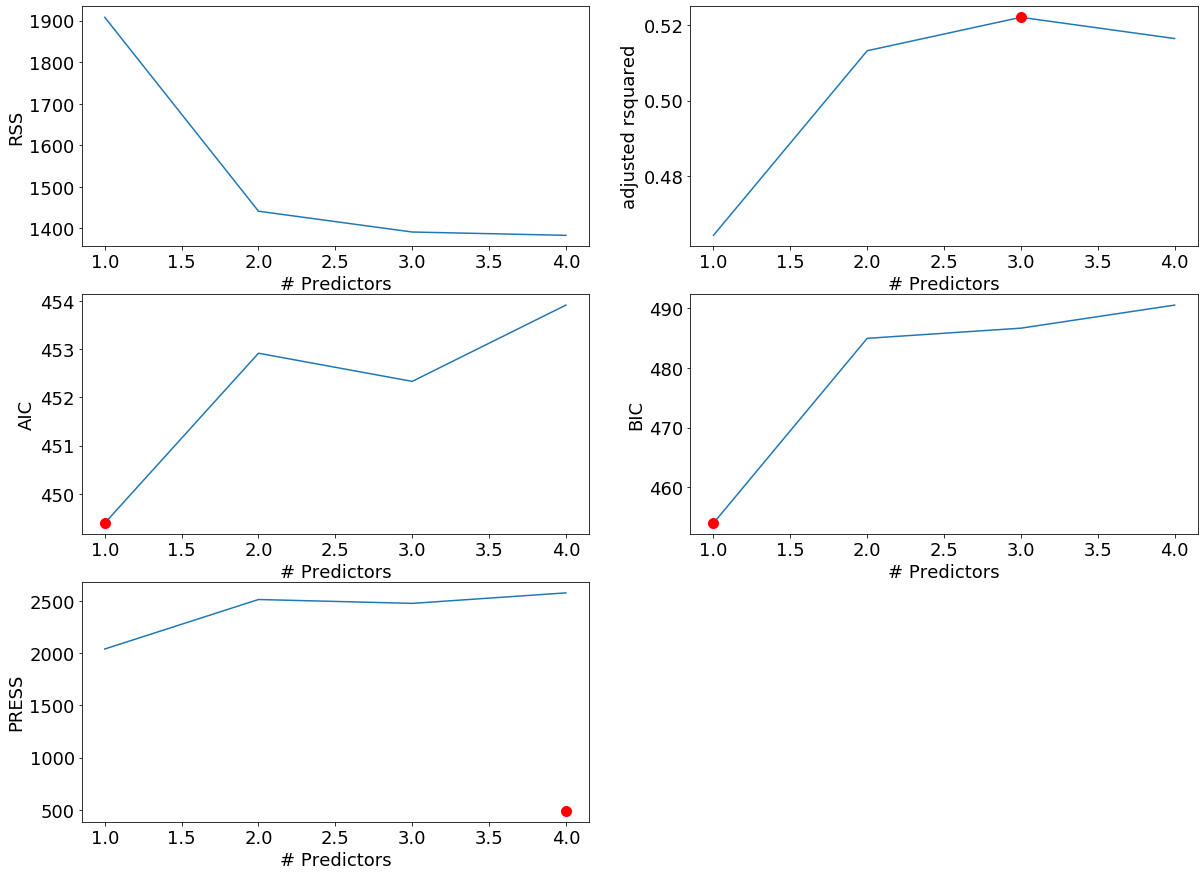

In [52]:
plot_model_stats(models_best)

*Interpretation*

We can see above that all the model selection criteria point us to model #2 - looking at the plots, they all have the "elbow" at model #2.

In [53]:
model_select = models_best.iloc[1,1]
model_select.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     websites_delivered   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     6.838
Date:                Wed, 20 Nov 2019   Prob (F-statistic):           8.64e-08
Time:                        20:20:03   Log-Likelihood:                -212.46
No. Observations:                  73   AIC:                             452.9
Df Residuals:                      59   BIC:                             485.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.7989      0.402     16.914      0.000       5.995       7.603
process_change_0    -1.4176      0.632     -2.244      0.029      -2.682      -0.153
process_change_1     8.2165      0.697     11.794      0.000       6.823       9.610
team_number_1       -3.4197      1.833     -1.865      0.067      -7.088       0.249
team_number_2       -0.7054      1.833     -0.385      0.702      -4.374       2.963
team_number_3       -2.2768      1.833     -1.242      0.219      -5.945       1.392
team_number_4        0.0089      1.833      0.005      0.996      -3.660       3.677
team_number_5        2.2946      1.833      1.252      0.216      -1.374       5.963
team_number_6        0.0089      1.833      0.005      0.996      -3.660       3.677
team_number_7        5.0516      2.362      2.139      0.037       0.326       9.777
team_number_8        5.5516      2.362      2.351      0.022       0.826      10.277
team_number_9        3.2406      1.960      1.654      0.104      -0.681       7.162
team_number_10      -1.8350      2.127     -0.863      0.392      -6.091       2.421
team_number_11       0.5292      2.721      0.195      0.846      -4.915       5.974
team_number_12      -0.5155      3.365     -0.153      0.879      -7.248       6.217
team_number_13      -1.1340      1.833     -0.619      0.539      -4.802       2.535
==============================================================================
Omnibus:                        2.302   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.316   Jarque-Bera (JB):                2.027
Skew:                           0.296   Prob(JB):                        0.363
Kurtosis:                       2.437   Cond. No.                     1.78e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.8e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [54]:
def calc_mspr(model, X, y):
    yhat = model.predict(X)
    yi = y
    MSPR = np.sum((yi-yhat)**2/X.shape[0])
    return(MSPR)

In [55]:
vars_select = list(model_select.params.index)
vars_select

['const',
 'process_change_0',
 'process_change_1',
 'team_number_1',
 'team_number_2',
 'team_number_3',
 'team_number_4',
 'team_number_5',
 'team_number_6',
 'team_number_7',
 'team_number_8',
 'team_number_9',
 'team_number_10',
 'team_number_11',
 'team_number_12',
 'team_number_13']

In [56]:
X_pred = scale_encode(fit_df=X, trans_df=X, scale_num=False)
X_pred = sm.add_constant(X_pred)
X_pred.columns

/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Index(['const', 'backlog', 'team_experience', 'process_change_0',
       'process_change_1', 'team_number_1', 'team_number_2', 'team_number_3',
       'team_number_4', 'team_number_5', 'team_number_6', 'team_number_7',
       'team_number_8', 'team_number_9', 'team_number_10', 'team_number_11',
       'team_number_12', 'team_number_13'],
      dtype='object')

In [57]:
MSPR = calc_mspr(model=model_select, X=X_pred[vars_select], y=y)
MSPR

19.74426689685728

*Interpretation:*

60% of the variation in `Websites.delivered` is explained by our model (with variables `Process.change` and `Team.number`). We can also see that the MSE and the MSPR are not significantly different. Thus, the model is certainly not a perfect fit for the give data set. However, it does a good enough job of pointing the management in the right direction as to where it should focus its efforts to drive more efficiency. 

- First recommendation to the management would be that a change in website development process can significantly improve the production output
- Second, teams 5,7, 8, 9 are doing a good job and are surely the high performers (higher $\beta$'s). While, team number 3 and 10 are laggind behind.


**Question 5** Refer to the Prostate cancer data set. Serum prostate-specific antigen (PSA) was determined in 97 men with advanced prostate cancer. PSA is a well-established screening test for prostate cancer and the oncologists wanted to examine the correlation between level of PSA and a number of clinical measures for men who were about to undergo radical prostatectomy. The measures are cancer volume, prostate weight, patient age, the amount of benign prostatic hyperplasia, seminal vesicle invasion, capsular penetration, and Gleason score. (15 Pts) 

**(a)** Select a random sample of 65 observations to use as the model-building data set. Develop a best subset model for predicting PSA. Justify your choice of model. Assess your model's ability to predict and discuss its usefulness to the oncologists. (5pts)

**Solution:**

In [109]:
prostate_data = pd.read_csv("data/Prostate Cancer.csv")
mapper = {"PSA level": "psa_level",
          "Cancer volume": "cancer_volume",
          "Weight": "weight",
          "Benign prostatic hyperplasia": "benign_prostatic_hyperplasia",
          "Seminal vesicle invasion": "seminal_vesicle_invasion",
          "Age": "age" ,
          "Capsular penetration": "capsular_penetration",
          "Gleason score": "gleason_score"
         }


prostate_data = prostate_data.rename(columns=mapper)

In [110]:
prostate_data["seminal_vesicle_invasion"] = prostate_data["seminal_vesicle_invasion"].astype("category")
prostate_data["gleason_score"] = prostate_data["gleason_score"].astype("category")
prostate_data.describe()

,psa_level,cancer_volume,weight,age,benign_prostatic_hyperplasia,capsular_penetration
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,23.730134,6.998682,45.491361,63.865979,2.534725,2.245367
std,40.782925,7.880869,45.705053,7.445117,3.031176,3.783329
min,0.651000,0.259200,10.697000,41.000000,0.000000,0.000000
25%,5.641000,1.665300,29.371000,60.000000,0.000000,0.000000
50%,13.330000,4.263100,37.338000,65.000000,1.349900,0.449300
75%,21.328000,8.414900,48.424000,68.000000,4.758800,3.254400
max,265.072000,45.604200,450.339000,79.000000,10.277900,18.174100


In [111]:
random.seed(1234)
train_ind = np.random.randint(0, prostate_data.shape[0], 65)
test_ind = list(set(range(prostate_data.shape[0]))^set(train_ind))
train_df = prostate_data.iloc[train_ind,:]
test_df = prostate_data.iloc[test_ind,:]

In [112]:
prostate_data.corr()

,psa_level,cancer_volume,weight,age,benign_prostatic_hyperplasia,capsular_penetration
psa_level,1.000000,0.624151,0.026213,0.017199,-0.016486,0.550793
cancer_volume,0.624151,1.000000,0.005107,0.039094,-0.133209,0.692897
weight,0.026213,0.005107,1.000000,0.164324,0.321849,0.001579
age,0.017199,0.039094,0.164324,1.000000,0.366341,0.099555
benign_prostatic_hyperplasia,-0.016486,-0.133209,0.321849,0.366341,1.000000,-0.083009
capsular_penetration,0.550793,0.692897,0.001579,0.099555,-0.083009,1.000000


In [119]:
features = ['cancer_volume', 'weight', 'age',
            'benign_prostatic_hyperplasia', 'seminal_vesicle_invasion',
            'gleason_score']
X_train = train_df[features]
y_train = train_df['psa_level']

In [120]:
models_best = best_subset_models(X=X_train, y=y_train)
models_best

Processed 6 models on 1 predictors in 0.040549516677856445 seconds.


/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/from

ValueError: The indices for endog and exog are not aligned

/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in th

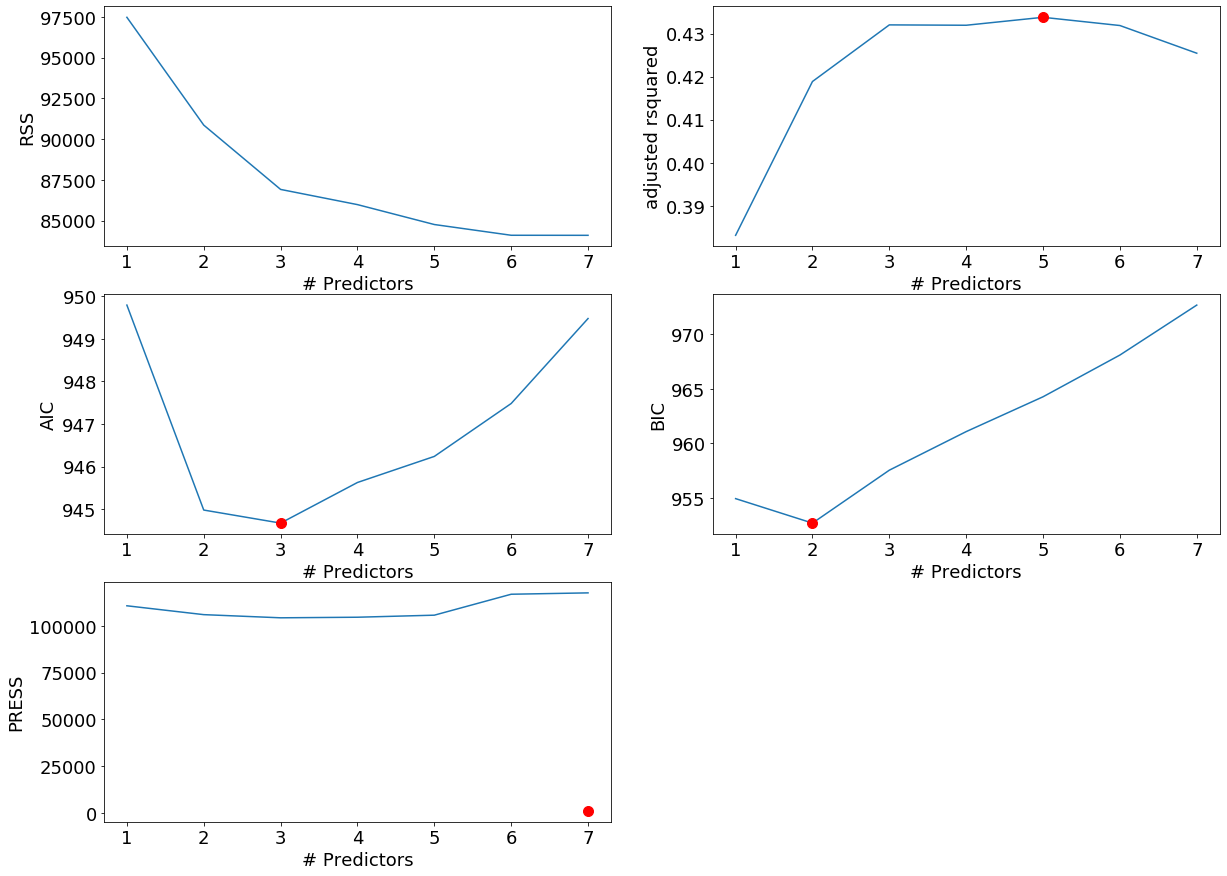

In [121]:
plot_model_stats(models_best)

In [123]:
model_select = models_best.iloc[1,1]
model_select.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              psa_level   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     35.60
Date:                Wed, 20 Nov 2019   Prob (F-statistic):           3.10e-12
Time:                        23:12:20   Log-Likelihood:                -469.49
No. Observations:                  97   AIC:                             945.0
Df Residuals:                      94   BIC:                             952.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          8.9226      4.210      2.120      0.037       0.564      17.281
cancer_volume                  2.4767      0.495      5.003      0.000       1.494       3.460
seminal_vesicle_invasion_0    -7.8622      3.451     -2.278      0.025     -14.714      -1.011
seminal_vesicle_invasion_1    16.7848      6.430      2.610      0.011       4.017      29.553
==============================================================================
Omnibus:                       98.023   Durbin-Watson:                   0.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1229.498
Skew:                           3.259   Prob(JB):                    1.04e-267
Kurtosis:                      19.178   Cond. No.                     1.62e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.08e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [81]:
anova_lm(model_select)

AttributeError: 'PandasData' object has no attribute 'design_info'

In [125]:
vars_select = list(model_select.params.index)
X_pred_tr = scale_encode(fit_df=X_train, trans_df=X_train, scale_num=False)
X_pred_tr = sm.add_constant(X_pred_tr)
X_pred_tr.columns

/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Index(['const', 'cancer_volume', 'weight', 'age',
       'benign_prostatic_hyperplasia', 'seminal_vesicle_invasion_0',
       'seminal_vesicle_invasion_1', 'gleason_score_6', 'gleason_score_7',
       'gleason_score_8'],
      dtype='object')

In [126]:
MSPR = calc_mspr(model=model_select, X=X_pred_tr[vars_select], y=y_train)
MSPR

958.8056067514424

*Interpretation:*

We can see that, based on the plots and the above summary, model #2 is where the "elbow" occurs for various measures. 

43% of the variation in PSA.level is explained by the variables "Cancer Volume" and "Seminal vesicle invasion". This could be significant considering the nature of the problem we are trying to solve since any correlation can lead the oncologists early detection of the ailment.

- The oncologists would be able predict the PSA based on the volume of cancer and if there was a seminal vescicle invasion.
- We can see that both these variables are postively correlated to the PSA level, which means the oncologists can determine early if a patient is in the "high-risk" zone and possibly start early treatment.



**(b)** Fit the regression model identified in part a to the validation data set. Compare the estimated regression coefficients and their estimated standard errors with those obtained in part a. Also compare the error mean square and coefficients of multiple determination. Does the model fitted to the validation data set yield similar estimates as the model fitted to the model-building data set? (5pts)

In [100]:
model_train = model_select

In [133]:
X_test = test_df[features]
y_test = test_df["psa_level"]
X_pred_te = scale_encode(fit_df=X_test, trans_df=X_test, scale_num=False)
X_pred_te = sm.add_constant(X_pred_te)[vars_select]
X_pred_te.columns

/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Index(['const', 'cancer_volume', 'seminal_vesicle_invasion_0',
       'seminal_vesicle_invasion_1'],
      dtype='object')

In [134]:
model_test = sm.OLS(y_test, X_pred_te).fit()
model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              psa_level   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     37.31
Date:                Wed, 20 Nov 2019   Prob (F-statistic):           1.42e-10
Time:                        23:23:20   Log-Likelihood:                -250.43
No. Observations:                  52   AIC:                             506.9
Df Residuals:                      49   BIC:                             512.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         24.1768      7.502      3.223      0.002       9.100      39.254
cancer_volume                  2.8125      0.738      3.813      0.000       1.330       4.295
seminal_vesicle_invasion_0   -24.5785      5.914     -4.156      0.000     -36.462     -12.695
seminal_vesicle_invasion_1    48.7553     12.247      3.981      0.000      24.143      73.367
==============================================================================
Omnibus:                       23.332   Durbin-Watson:                   1.429
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.506
Skew:                           0.648   Prob(JB):                     7.65e-34
Kurtosis:                      11.289   Cond. No.                     1.18e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.31e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [135]:
model_train.conf_int()

,0,1
const,0.564305,17.280895
cancer_volume,1.493868,3.459580
seminal_vesicle_invasion_0,-14.713650,-1.010814
seminal_vesicle_invasion_1,4.017026,29.552639


In [136]:
model_test.conf_int()

,0,1
const,9.100036,39.253527
cancer_volume,1.330073,4.294882
seminal_vesicle_invasion_0,-36.462429,-12.694565
seminal_vesicle_invasion_1,24.143474,73.367083


*Interpretation*

*Comparing Coeficients and their s(b):* 

- We can see that all the three $\beta$ s for the validation model have significantly higher standard errors compared to those for the ones in training model. We can also see this in the 95% confidence interval. 
- Also, there is some material differences in the values for the Intercept and the $\beta$ for `Seminal.vesicle.invasion`.

*Comparing MSE and R-squared:* 

- MSE for the validation model is higher that the one for training model.
- Also, multiple$R^2$ for validation model is lower than that for the training model.
- This means that the training model is a better fit to the training data compared to validation model is to the validation data.
- The above effect is mostly due to the fact that there are more data points in training data set compare to the validation data set.

**(c)** Calculate the mean squared prediction error (equation 9.20 on the book) and compare it to MSE obtained from the model-building data set. Is there evidence of a substantial bias problem in MSE here? (5pts)


In [137]:
MSPR = calc_mspr(model=model_test, X=X_pred_te, y=y_test)
MSPR

892.6272298667564


*Interpretation:*

We can see that the MSPR obtained in part(c) is not significantly different than MSE in part(a). Thus, we can say that there is no evidence of substantial bias problem here.

**Question 6** Refer to Market share data set. Company executives want to be able to predict market share of their product (Y) based on merchandise price (X1), the gross Nielsen rating points (X2, an index of the amount of advertising exposure that the product received); the presence or absence of a wholesale pricing discount (X3 = 1 if discount present: otherwise X3 = 0); the presence or absence of a package promotion during the period (X4 = 1 if promotion present: otherwise X4 = 0): and year (X5). Code year as a nominal level variable and use 2000 as the referent year. (20 pts)

**(a)** Using only first-order terms for predictor variables, find the three best subset regression models according to the SBCp criterion. (7 pts)

**Solution:**

In [163]:
market_data = pd.read_csv("data/Market Share.csv")
market_data.columns

Index(['Market.Share', 'Price', 'Gross.Nielsen.Rating.Points',
       'Discount.Price', 'Package.Promotion', 'Month', 'Year'],
      dtype='object')

In [164]:
mapper = {
    "Market.Share": "market_share",
    "Price": "price",
    "Gross.Nielsen.Rating.Points": "nielsen_rating",
    "Discount.Price": "discount_price",
    "Package.Promotion": "package_promotion",
    "Month": "month",
    "Year": "year"    
}
market_data = market_data.rename(columns=mapper)

In [165]:
features = ["price", "nielsen_rating", "discount_price",
            "package_promotion", "year"]
X = market_data[features]
y = market_data["market_share"]

In [144]:
models_best = best_subset_models(X=X, y=y)
models_best

Processed 5 models on 1 predictors in 0.04529690742492676 seconds.
Processed 10 models on 2 predictors in 0.03924441337585449 seconds.
Processed 10 models on 3 predictors in 0.037262916564941406 seconds.
Processed 5 models on 4 predictors in 0.019700288772583008 seconds.
Processed 1 models on 5 predictors in 0.004839181900024414 seconds.


/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


,RSS,model
1,0.916724,<statsmodels.regression.linear_model.Regressio...
2,0.821468,<statsmodels.regression.linear_model.Regressio...
3,0.717954,<statsmodels.regression.linear_model.Regressio...
4,0.689645,<statsmodels.regression.linear_model.Regressio...
5,0.686662,<statsmodels.regression.linear_model.Regressio...


/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in th

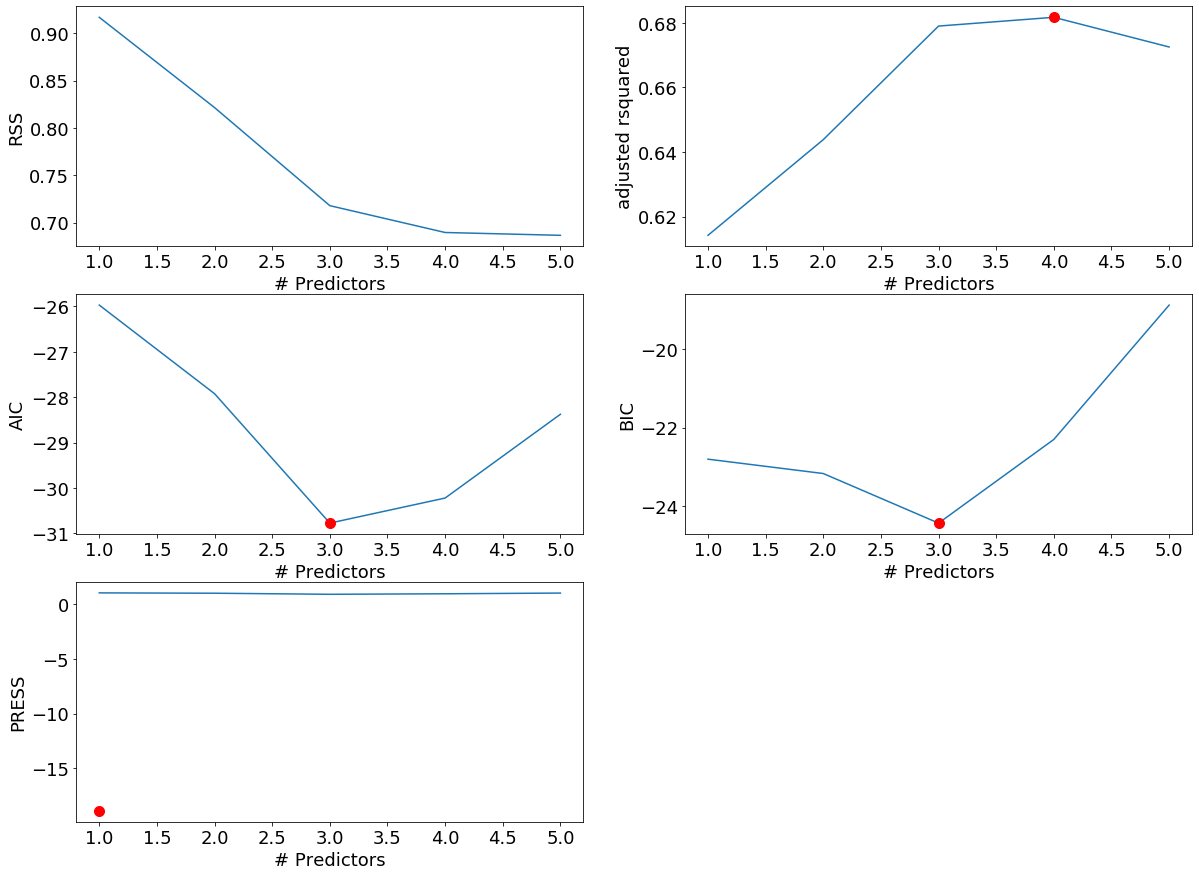

In [145]:
plot_model_stats(models_best)

**(b)** Using forward stepwise regression, find the best subset of predictor variables to predict market share of their product. Use α limits of 0.10 and .15 for adding or deleting a predictor, respectively. (7pts)

**Solution:**

In [175]:
models_fwd = forward_stepwise(X=X, y=y)

Processed  5 models on 1 predictors in 0.04152703285217285 seconds.
Processed  4 models on 2 predictors in 0.01680612564086914 seconds.
Processed  3 models on 3 predictors in 0.014609575271606445 seconds.
Processed  2 models on 4 predictors in 0.008723258972167969 seconds.
Processed  1 models on 5 predictors in 0.005418539047241211 seconds.


/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in th

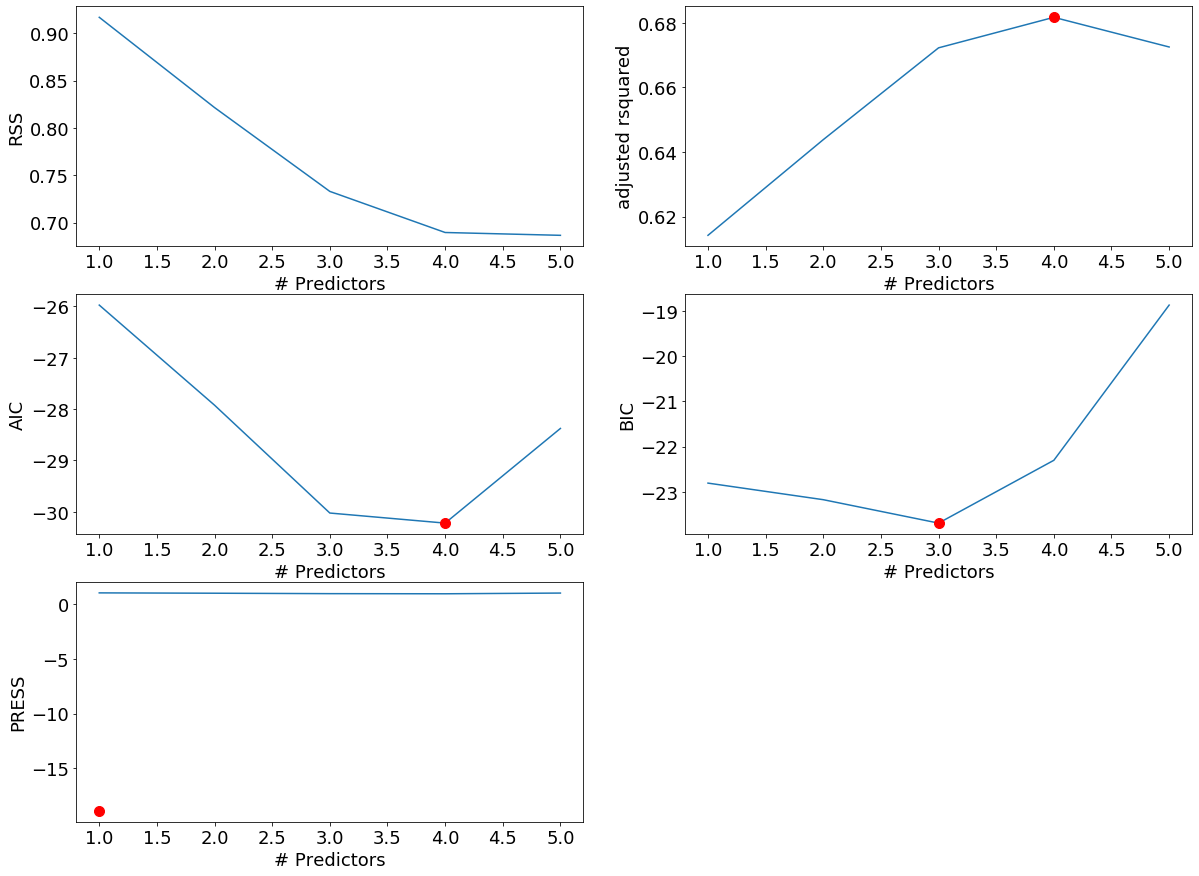

In [176]:
plot_model_stats(models_best=models_fwd)

In [177]:
models_bwd = backward_stepwise(X=X, y=y)

Processed  5 models on 6 predictors in 0.03521609306335449 seconds.
Processed  4 models on 5 predictors in 0.018202781677246094 seconds.
Processed  3 models on 4 predictors in 0.012745857238769531 seconds.
Processed  2 models on 3 predictors in 0.007626056671142578 seconds.
Processed  1 models on 2 predictors in 0.002999544143676758 seconds.


/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/home/srk-apts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in th

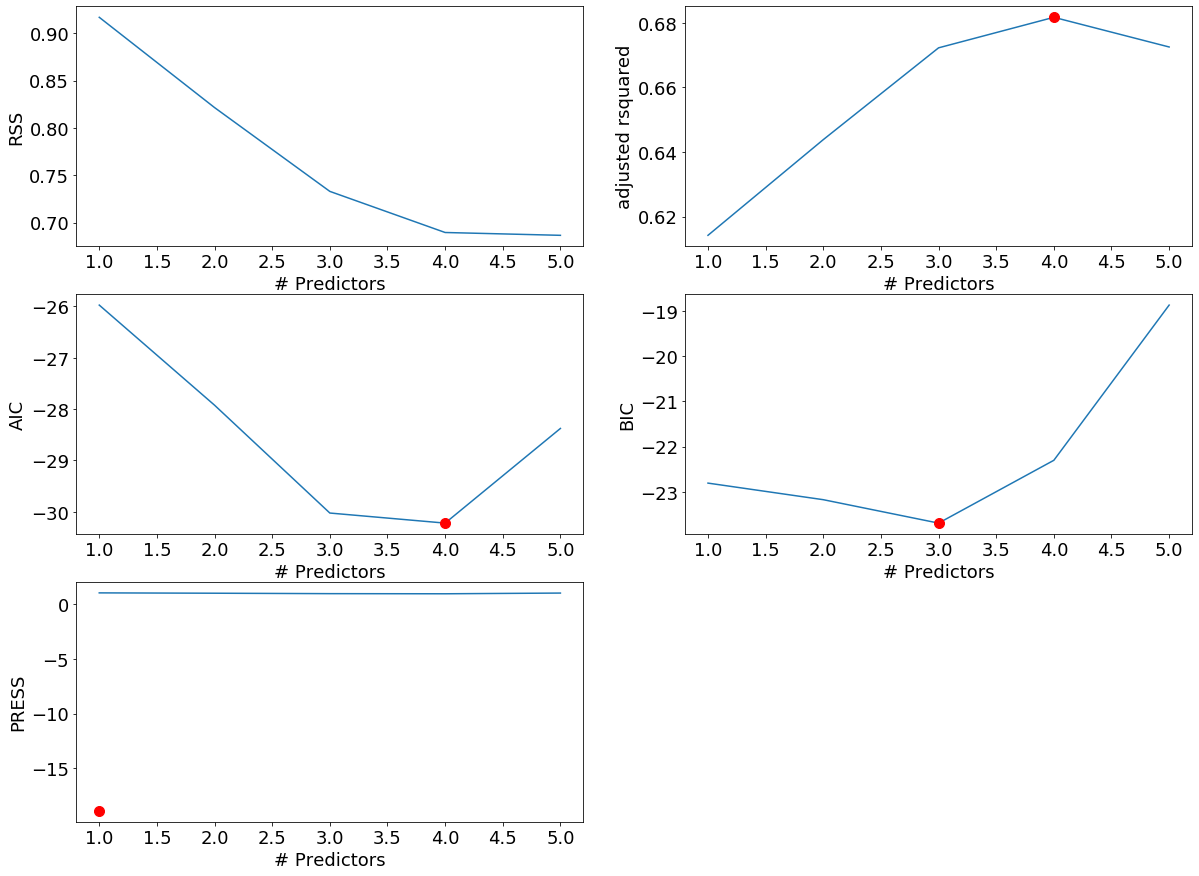

In [172]:
plot_model_stats(models_best=models_fwd)